In [59]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [60]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [61]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_dataset_path = '../Dataset/Training/Clean_train_data_nostem.csv'
# valid_dataset_path = './dataset-emosi/valid_preprocess.csv'

In [62]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['tweet', 'label']
# valid_df.columns = ['label', 'tweet']

In [63]:
train_df.head(10)

,tweet,label
0,"['pagi', 'emosi']",Anger
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",Anger
2,"['emosi', 'liat']",Anger
3,"['aib', 'bodoh', 'aib', 'muncul', 'tindakan', ...",Anger
4,"['menyebalkan', 'bodoh']",Anger
5,"['asli', 'malu', 'maluin', 'indo', 'tolol', 'r...",Anger
6,"['drama', 'abg', 'tolol']",Anger
7,"['emosi', 'katla', 'kemarin', 'keterangannya',...",Anger
8,"['bangsat', 'tribute', 'no', 'bencana', 'no', ...",Anger
9,"['pergi', 'teriak', 'nangis', 'sekencang', 'ke...",Anger


In [64]:
train_df['label']

0       Anger
1       Anger
2       Anger
3       Anger
4       Anger
        ...  
7075      Sad
7076      Sad
7077      Sad
7078      Sad
7079      Sad
Name: label, Length: 7080, dtype: object

In [65]:
def get_label_idx(label):
    if label == 'Anger':
        return 0
    if label == 'Joy':
        return 1
    if label == 'Fear':
        return 2
    if label == "Love":
        return 3
    if label == "Sad":
        return 4
    if label == "Neutral":
        return 5

train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [66]:
unique_labels = train_df['label'].unique()
print(unique_labels)


[0 2 1 3 5 4]


In [67]:
train_df

,tweet,label
0,"['pagi', 'emosi']",0
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",0
2,"['emosi', 'liat']",0
3,"['aib', 'bodoh', 'aib', 'muncul', 'tindakan', ...",0
4,"['menyebalkan', 'bodoh']",0
...,...,...
7075,"['pagi', 'seisi', 'semesta', 'sujud', 'zat', '...",4
7076,"['engkau', 'pergi', 'engkau', 'meninggalkan', ...",4
7077,"['kalah', 'tersakiti']",4
7078,"['apakabar', 'ku', 'fikiranku', 'menentu']",4


In [68]:
# filter dataset yang labelnya 0-4 aja
train_df = train_df[train_df['label'] < 5]
# valid_df = valid_df[valid_df['label'] < 5]

In [69]:
train_df['label'].value_counts()

label
1    1275
0    1130
4    1003
2     911
3     760
Name: count, dtype: int64

In [70]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

C:\Users\TEMP\AppData\Local\Temp\ipykernel_12140\4119128493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)


0                                           pagi emosi
1    stabilitas negara memange tahun negara aman sb...
2                                           emosi liat
3    aib bodoh aib muncul tindakan kekejian sembuny...
4                                    menyebalkan bodoh
Name: preprocessed, dtype: object

## Generate Padded Sequence

In [71]:
# Parameters

vocab_size = 20000 #ukuran kosakata yang akan digunakan
max_length = 100 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [72]:
from sklearn.model_selection import train_test_split

# Bagi dataset menjadi data pelatihan dan data validasi
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate word index dictionary untuk kalimat-kalimat pelatihan
tokenizer.fit_on_texts(train_df['preprocessed'])
word_index = tokenizer.word_index
print(word_index)

# Convert kalimat-kalimat pelatihan menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Convert kalimat-kalimat validasi menjadi urutan kata
valid_sequences = tokenizer.texts_to_sequences(valid_df['preprocessed'])
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)


{'<OOV>': 1, 'suka': 2, 'sedih': 3, 'semangat': 4, 'takut': 5, 'pagi': 6, 'marah': 7, 'bodoh': 8, 'bikin': 9, 'malu': 10, 'tuh': 11, 'sayang': 12, 'si': 13, 'cinta': 14, 'pas': 15, 'bahagia': 16, 'emosi': 17, 'kasih': 18, 'wkwk': 19, 'pakai': 20, 'semoga': 21, 'anak': 22, 'kaget': 23, 'liat': 24, 'yaa': 25, 'kabar': 26, 'tolol': 27, 'kak': 28, 'teman': 29, 'ku': 30, 'sepi': 31, 'benci': 32, 'iya': 33, 'senang': 34, 'ngeri': 35, 'kek': 36, 'nangis': 37, 'kecewa': 38, 'kadang': 39, 'baca': 40, 'gini': 41, 'deh': 42, 'bangsat': 43, 'kaya': 44, 'lupa': 45, 'salah': 46, 'biar': 47, 'gimana': 48, 'sakit': 49, 'bilang': 50, 'makan': 51, 'bangun': 52, 'sehat': 53, 'lagu': 54, 'kemarin': 55, 'nonton': 56, 'kesal': 57, 'tidur': 58, 'alhamdulillah': 59, 'bagus': 60, 'happy': 61, 'allah': 62, 'denise': 63, 'waktu': 64, 'beli': 65, 'hati': 66, 'lucu': 67, 'you': 68, 'eh': 69, 'rumah': 70, 'cowok': 71, 'panik': 72, 'haha': 73, 'jimin': 74, 'cewek': 75, 'bicara': 76, 'selamat': 77, 'diam': 78, 'main'

In [73]:
# ## Tokenization
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# # Generate word index dictionary for the training sentences
# tokenizer.fit_on_texts(train_df['preprocessed'])
# word_index = tokenizer.word_index
# print(word_index)

# # Convert the training sentences into word sequences
# train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
# train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# # Convert the validation sentences into word sequences
# valid_sequences = tokenizer.texts_to_sequences(valid_df['tweet'])
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

In [74]:
# Split Dataset


In [75]:
# import pickle

# # Simpan tokenizer ke dalam file
# with open('tokenizer-3classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [76]:
print(train_padded[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   3  83 377 767]


## Word Embedding

In [77]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in train_df['preprocessed']]
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [78]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [79]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[1000])
print(word)

('part', array([-0.03638254, -0.17191845,  0.21613845,  0.07079736,  0.08640318,
        0.03443202,  0.20712256, -0.10950641]))


## Build and Compile Model

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

c:\Users\TEMP\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 8)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │        32,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,461 (919.77 KB)

 Trainable params: 75,461 (294.77 KB)

 Non-trainable params: 160,000 (625.00 KB)

In [81]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_2
Weights Shape (Tensor 0): (20000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.21213259 -1.9163433   1.3838539  ... -0.6998992   3.5081978
   0.14272758]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: dense_8
Weights Shape (Tensor 0): (8, 256)
Weights (Tensor 0):
[[ 0.0882217   0.04486489 -0.01952496 ... -0.10708499 -0.00139311
  -0.09995635]
 [ 0.11997721 -0.12369577  0.0350993  ...  0.00032204  0.11074048
  -0.11316617]
 [ 0.03505617  0.04177929  0.12559855 ...  0.03268318 -0.12606491
  -0.06435985]
 ...
 [ 0.08564436  0.1219382  -0.07776481 ...  0.06247698  0.03193395
   0.07432151]
 [-0.03780063  0.11257923  0.15073532 ...  0.0287457  -0.0716408

## Train Model

In [82]:
num_epochs = 100

history = model.fit(train_padded, train_df['label'], epochs=num_epochs, validation_data=(valid_padded, valid_df['label']), verbose=1)


Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.2263 - loss: 1.5971 - val_accuracy: 0.2746 - val_loss: 1.5710
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2771 - loss: 1.5641 - val_accuracy: 0.2618 - val_loss: 1.5488
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3110 - loss: 1.5296 - val_accuracy: 0.3937 - val_loss: 1.4769
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3567 - loss: 1.4726 - val_accuracy: 0.4222 - val_loss: 1.4238
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3970 - loss: 1.4282 - val_accuracy: 0.4203 - val_loss: 1.4213
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4437 - loss: 1.3564 - val_accuracy: 0.4636 - val_loss: 1.3340
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4705 - loss: 1.2901 - val_accuracy: 0.4892 - val_loss: 1.2564
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5090 - loss: 1.2328 - 

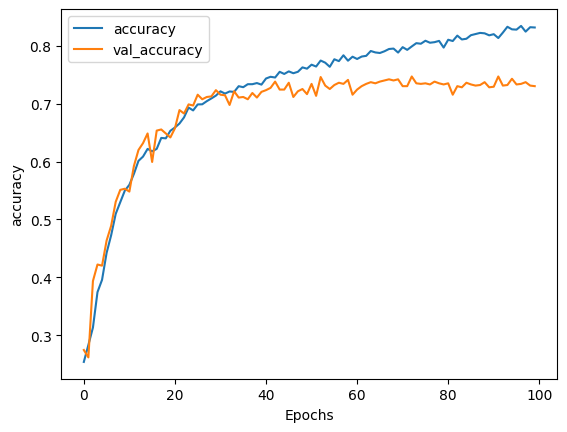

In [83]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

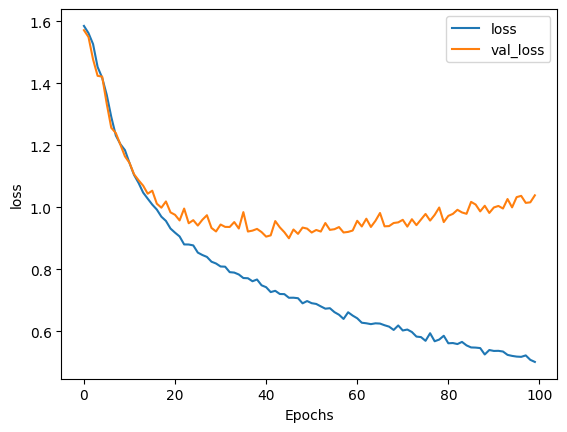

In [84]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [85]:
# saved model
model.save('model-5classes-no-stemming-ANN.h5')

In [86]:
## test model with predict one example sentence
sample_text = ["aduh gimana ya ini takut"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
print(model.predict(sample_padded))

## convert predict to label
def get_label(predict):
    if predict == 0:
        return 'Anger'
    if predict == 1:
        return 'Joy'
    if predict == 2:
        return 'Fear'
    if predict == 3:
        return 'Love'
    if predict == 4:
        return 'Sad'
    # if predict == 5:
    #     return 'Neutral'
    
    
print(get_label(np.argmax(model.predict(sample_padded))))    



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[[2.0146128e-06 8.1145129e-04 9.9909556e-01 3.6689140e-05 5.4335935e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fear


In [87]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

print (y_pred_classes.shape)
print (y_pred.shape)

# Mencetak classification report
print(classification_report(valid_df["label"], y_pred_classes))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1016,)
(1016, 5)
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       245
           1       0.67      0.74      0.70       257
           2       0.79      0.71      0.75       174
           3       0.63      0.79      0.70       139
           4       0.78      0.70      0.74       201

    accuracy                           0.73      1016
   macro avg       0.74      0.73      0.73      1016
weighted avg       0.74      0.73      0.73      1016



In [88]:
#save model
model.save('./model/model-ANN-word2vec-5-classes-no-stemming.h5')

In [89]:
import numpy as np
import tensorflow as tf

# Inisialisasi bobot kernel dengan ukuran 5
kernel_size = 5
num_filters = 1
embedding_dim = 8

# Membuat bobot kernel dengan inisialisasi Glorot uniform
initializer = tf.keras.initializers.GlorotUniform()
kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# Dibulatkan ke angka terdekat
kernel_weights_rounded = np.round(kernel_weights, decimals=2)

print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
print(kernel_weights_rounded)
print("Shape bobot kernel:", kernel_weights.shape)


Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):
[[[ 0.17]
  [-0.31]
  [-0.23]
  [-0.22]
  [ 0.06]
  [-0.03]
  [ 0.22]
  [-0.03]]

 [[ 0.28]
  [ 0.02]
  [-0.25]
  [ 0.12]
  [-0.11]
  [-0.04]
  [-0.18]
  [ 0.23]]

 [[-0.22]
  [ 0.13]
  [ 0.08]
  [ 0.36]
  [ 0.21]
  [ 0.33]
  [-0.09]
  [-0.07]]

 [[-0.36]
  [ 0.34]
  [ 0.33]
  [ 0.32]
  [ 0.05]
  [-0.27]
  [ 0.  ]
  [ 0.18]]

 [[-0.05]
  [ 0.21]
  [ 0.04]
  [ 0.28]
  [ 0.26]
  [-0.3 ]
  [ 0.01]
  [-0.35]]]
Shape bobot kernel: (5, 8, 1)
